# Multilayer Perceptron (MLP) with Backpropagation (BP) algorithm

Implementation of a multilayer perceptron with backpropagation algorithm for classification of data contained in a csv file, in which there is an input layer, a hidden layer with n neurons and an output layer with k neurons.

## Perceptron multicapa con algoritmo de retropropagación

Implementación de un perceptron multicapa con algoritmo de retropropagación para la clasificación de datos contenidos en un archivo csv., en la cual se tiene una capa de entrada, una capa oculta con n neuronas y una capa de salida con k neuronas.

In [47]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Callable, NewType

### Activation functions

#### Funciones de activación

In [48]:
# Auxiliar functions
# Please execute this cell before running the rest of the notebook ->

def sigmoid(x):
    """
    Sigmoid activation function

    Parameters
    ----------
    x : array_like
        Input value

    Returns
    -------
    array_like
        Sigmoid of x

    """
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """
    Sigmoid derivative function

    Parameters
    ----------
    x : array_like
        Input value

    Returns
    -------
    array_like
        Sigmoid derivative of x

    """
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    """
    Hyperbolic tangent activation function

    Parameters
    ----------
    x : array_like
        Input value

    Returns
    -------
    array_like
        Hyperbolic tangent of x

    """
    return np.tanh(x)

def tanh_derivative(x):
    """
    Hyperbolic tangent derivative function

    Parameters
    ----------
    x : array_like
        Input value

    Returns
    -------
    array_like
        Hyperbolic tangent derivative of x

    """
    return 1 - np.tanh(x) ** 2

def relu(x):
    """
    Rectified Linear Unit activation function

    Parameters
    ----------
    x : array_like
        Input value

    Returns
    -------
    array_like
        Rectified Linear Unit of x

    """
    return np.maximum(0, x)

def relu_derivative(x):
    """
    Rectified Linear Unit derivative function

    Parameters
    ----------
    x : array_like
        Input value

    Returns
    -------
    array_like
        Rectified Linear Unit derivative of x

    """
    return 1. * (x > 0)

def softmax(x):
    """
    Softmax activation function

    Parameters
    ----------
    x : array_like
        Input value

    Returns
    -------
    array_like
        Softmax of x

    """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    """
    Softmax derivative function

    Parameters
    ----------
    x : array_like
        Input value

    Returns
    -------
    array_like
        Softmax derivative of x

    """
    return softmax(x) * (1 - softmax(x))

list_activation_functions = [sigmoid, tanh, relu, softmax]
list_activation_functions_derivatives = [sigmoid_derivative, tanh_derivative, relu_derivative, softmax_derivative]

### Prediction function

In [49]:
def predictions(X: np.ndarray, W1: np.ndarray, W2: np.ndarray, af_hidden: Callable, af_output: Callable
            ) -> np.ndarray:
    """
    Predictions over the test set, given the weights of the first and second layer

    Parameters
    ----------
    X : np.ndarray
        Input data
    W1 : np.ndarray
        Weights of the first layer
    W2 : np.ndarray
        Weights of the second layer
    activation_function : str
        Activation function

    Returns
    -------
    np.ndarray
        Predicted output

    """
    # Initialize the output
    A2 = np.zeros((X.shape[0], 2))

    # Forward propagation for each sample
    for i in range(X.shape[0]):
        # Input layer
        Z1 = np.dot(W1, X[i])
        A1 = af_hidden(Z1)

        # Hidden layer
        Z2 = np.dot(W2, A1)
        A2[i] = af_output(Z2)

    return A2

### Data manipulation functions

#### Funciones de manipulación de datos

In [50]:
def separate_data(x: np.ndarray, y: np.ndarray, train_percentage=0.8):
    """
    Separates data into training and test sets

    Parameters
    ----------
    x : numpy.ndarray
        Input data
    y : numpy.ndarray
        Output data
    train_percentage : float, optional
        Percentage of data to be used for training. The default is 0.8.

    Returns
    -------
    x_train : numpy.ndarray
        Training data
    y_train : numpy.ndarray
        Training output data
    x_test : numpy.ndarray
        Test data
    y_test : numpy.ndarray
        Test output data

    """
    # Number of samples
    n_samples = x.shape[0]
    # Number of training samples
    n_train = int(n_samples * train_percentage)
    # Number of test samples
    # n_test = n_samples - n_train
    # Training data
    x_train = x[:n_train]
    y_train = y[:n_train]
    # Test data
    x_test = x[n_train:]
    y_test = y[n_train:]
    return x_train, y_train, x_test, y_test

 
# The csv files are in data folder, with names EarthSpace.csv and MedSci.csv
def load_data(file1: str, file2: str):
    """
    Loads the data from the csv files

    Returns
    -------
    x : np.ndarray
        Input data
    y : np.ndarray
        Output data

    """
    # Load data
    df_earthspace = pd.read_csv(file1, header=None) # shape (389,512)
    df_medsci = pd.read_csv(file2, header=None) # shape (330,512)
    # Concatenate data
    df = pd.concat([df_earthspace, df_medsci])
    # Input data
    x = df.to_numpy()
    # Build output data
    y = np.zeros((x.shape[0], 2))
    y[:df_earthspace.shape[0], 0] = 1
    y[df_earthspace.shape[0]:, 1] = 1
    
    return x, y

### Backpropagation algorithm

In [67]:
def mlp_bp(n: int, k: int, x: np.ndarray, y: np.ndarray,
           lr=0.001, epochs=1000, af_hidden_index=0, af_output_index=3,
           print_loss=True,  print_validation_loss=True,
           momentum=0
           ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Multi-layer perceptron with backpropagation algorithm, using stochastic gradient descent.

    Args:
    ----------------------------
        n: Number of neurons in the hidden layer.
        k: Number of classes.
        x: Input data.
        y: Target data.
        lr: Learning rate.
        epochs: Number of epochs.
        af_hidden_index: Index of the hidden layer activation function.
        af_output_index: Index of the output layer activation function.
        print_loss: Print loss after each epoch.
        print_validation_loss: Print validation loss after each epoch.
        momentum: Momentum parameter.

    Returns:
    ----------------------------
        w1: Weights for the hidden layer.
        w2: Weights for the output layer.
        convergence: List of the error values for each epoch.
        validation_convergence: List of the validation error values for each epoch.
    """
    convergence = []
    validation_convergence = []

    # Separate data into training and test sets
    x_train, y_train, x_test, y_test = separate_data(x, y)

    # Activation functions
    af_hidden = list_activation_functions[af_hidden_index]
    af_output = list_activation_functions[af_output_index]
    # Activation functions derivatives
    af_hidden_derivative = list_activation_functions_derivatives[af_hidden_index]
    af_output_derivative = list_activation_functions_derivatives[af_output_index]

    # Momentum parameter
    alpha = momentum

    # Initialize weights
    w1 = np.random.randn(n, x.shape[1]) # Hidden layer
    w2 = np.random.randn(k, n) # Output layer

    previous_delta_w1 = np.zeros(w1.shape)
    previous_delta_w2 = np.zeros(w2.shape)
    for _ in range(epochs):
        for example, target in zip(x_train, y_train):
            example = example[np.newaxis].T
            target = target[np.newaxis].T
            # Forward propagation
            z1 = (w1 @ example)
            a1 = af_hidden(z1)
            z2 = np.dot(w2, a1)
            a2 = af_output(z2)
 
            # Backpropagation
            delta2 = (a2 - target) * af_output_derivative(z2) # Output layer
            delta1 = np.dot(delta2.T, w2) * af_hidden_derivative(z1.T) # Hidden layer

            # Update weights
            w2 += (lr * delta2 @ a1.T) + (alpha * previous_delta_w2)
            w1 += (lr * delta1.T @ example.T) + (alpha * previous_delta_w1)

        # Predict
        y_pred = predictions(x_test, w1, w2, af_hidden, af_output)
        # Save the error
        error = np.mean(np.square(y_test - y_pred))
        convergence.append(error)
        if print_loss:
            print(f"Error: {np.mean(np.square(y_test - y_pred))}")

        # Save the validation error
        validation_loss = np.mean(np.square(y_test - y_pred))
        validation_convergence.append(validation_loss)
        if print_validation_loss:
            print(f"Validation error: {validation_loss}")

    # pint the final error
    print(f"Final error: {np.mean(np.square(y_test - y_pred))}")
    # pint the final validation error
    print(f"Final validation error: {validation_loss}")
    return w1, w2, convergence, validation_convergence


## Standardization and normalization of data
### Estandarización y normalización de datos

In [54]:
def standardize_data(x: np.ndarray) -> np.ndarray:
    """
    Standardizes the data

    Parameters
    ----------
    x : numpy.ndarray
        Input data

    Returns
    -------
    x : numpy.ndarray
        Standardized data

    """
    # Standardize data
    x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return x

def normalize_data(x: np.ndarray) -> np.ndarray:
    """
    Normalizes the data

    Parameters
    ----------
    x : numpy.ndarray
        Input data

    Returns
    -------
    x : numpy.ndarray
        Normalized data

    """
    # Normalize data
    x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
    return x

### Evaluation of the model

Final error: 6.981881228329525e-05
Final validation error: 6.981881228329525e-05


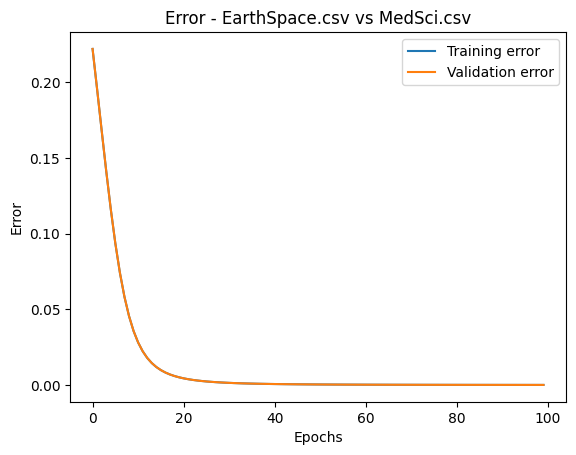

Final error: 5.5757707857694255e-06
Final validation error: 5.5757707857694255e-06


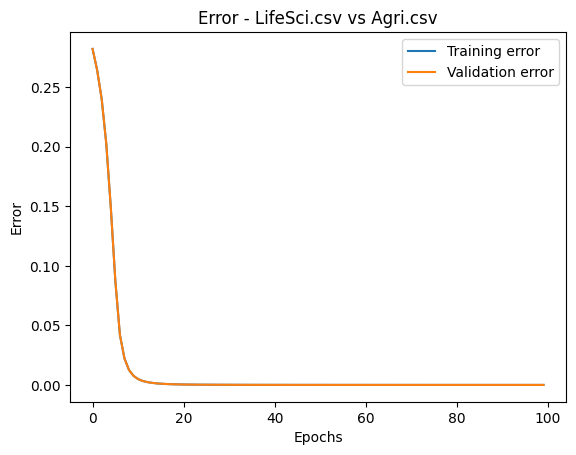

In [70]:
import os

root_dir = "data"
data_files = [["EarthSpace.csv", "MedSci.csv"], ["LifeSci.csv", "Agri.csv"] ]

transformations = [standardize_data, normalize_data]
option = 1

for data_file in data_files:
    # Load data
    x, y = load_data(os.path.join(root_dir, data_file[0]), os.path.join(root_dir, data_file[1]))
    # Transform data
    x = transformations[option](x)
    y = transformations[option](y)

    # Add bias
    x = np.insert(x, 0, 1, axis=1)

    # Train model
    w1, w2, convergence, validation_convergence = mlp_bp(3, 2, x, y, lr=0.001, epochs=100, af_hidden_index=0, af_output_index=3,
           print_loss=False,  print_validation_loss=False, momentum=0.2)
    # Plot error
    plt.plot(convergence, label="Training error")
    plt.plot(validation_convergence, label="Validation error")
    plt.legend()
    plt.title(f"Error - {data_file[0]} vs {data_file[1]}")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.show()